In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import numpy as np
import pandas as pd

In [4]:
import warnings 

warnings.filterwarnings('ignore')

# <center>Computational Mathematics Report's Experiments</center>
## <center>Support Vector Regression</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [16]:
def filter_svr_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['optimizer'] = cv_results['param_optimizer']
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly')
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'rbf')
    
    filtered_cv_results[['C', 'epsilon', 'fit_time', 
                         'train_r2', 'test_r2', 
                         'nr_train_sv', 'nr_test_sv']] = cv_results[['param_C', 'param_epsilon', 'mean_fit_time', 
                                                                     'mean_train_r2', 'mean_test_r2',
                                                                     'mean_train_nr_support_vectors', 'mean_test_nr_support_vectors']]
    
    filtered_cv_results['nr_train_sv'] = filtered_cv_results['nr_train_sv'].round().astype(int)
    filtered_cv_results['nr_test_sv'] = filtered_cv_results['nr_test_sv'].round().astype(int)

    return filtered_cv_results

## Epsilon-insensitive loss

### Primal formulation

In [23]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import epsilon_insensitive, squared_epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad, StochasticGradientDescent
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.datasets import make_regression
from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [24]:
def primal_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y),
            'nr_support_vectors': len(np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel())}

Fitting 3 folds for each of 9 candidates, totalling 27 fits


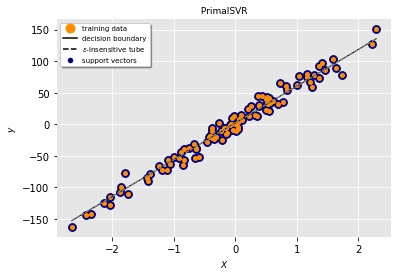

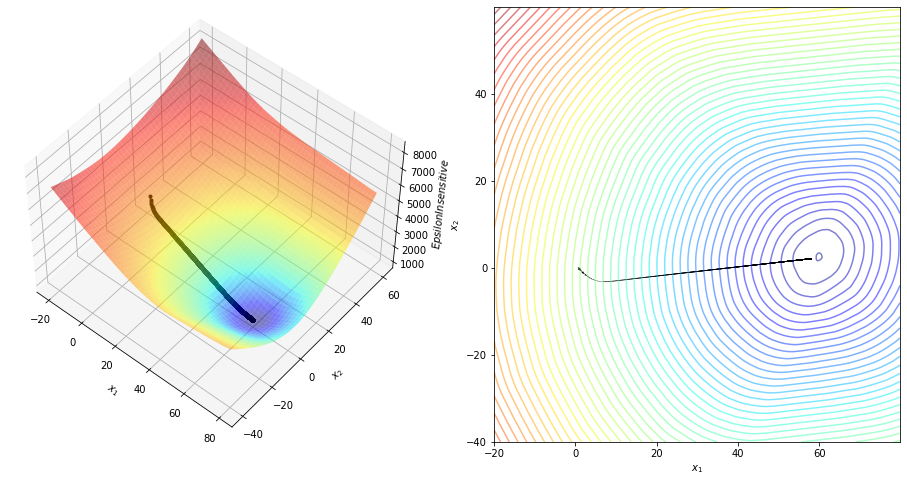

In [26]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)

grid = GridSearchCV(PrimalSVR(loss=epsilon_insensitive, optimizer=AdaGrad, 
                              learning_rate=1., max_iter=3200),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt best r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/svr_hyperplane.png')
plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-20, x_max=80, y_min=-40, y_max=60)
plt.savefig('./tex/img/svr_eps_loss.png')

In [27]:
custom_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svr_eps_cv_results.insert(0, 'optimizer', 'custom')
custom_primal_svr_eps_cv_results.style.hide_index()

optimizer,C,epsilon,fit_time,train_r2,test_r2,nr_train_sv,nr_test_sv
custom,1,0.100000,1.618582,0.976982,0.973644,65,33
custom,1,0.200000,1.657855,0.976942,0.973629,64,33
custom,1,0.300000,1.639000,0.976998,0.973540,64,33
custom,10,0.100000,1.657637,0.977600,0.974204,66,33
custom,10,0.200000,1.788188,0.977597,0.974061,66,33
custom,10,0.300000,1.738749,0.977586,0.973981,66,33
custom,100,0.100000,1.831985,0.977606,0.974266,66,33
custom,100,0.200000,1.726564,0.977645,0.974097,66,33
custom,100,0.300000,1.231514,0.977660,0.974156,66,33


In [29]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)

grid = GridSearchCV(SkLinearSVR(loss='epsilon_insensitive'),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt best r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [30]:
sklearn_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
sklearn_primal_svr_eps_cv_results.insert(0, 'optimizer', 'liblinear')
sklearn_primal_svr_eps_cv_results.style.hide_index()

optimizer,C,epsilon,fit_time,train_r2,test_r2,nr_train_sv,nr_test_sv
liblinear,1,0.100000,0.000767,0.918801,0.916815,66,33
liblinear,1,0.200000,0.000742,0.918801,0.916649,65,32
liblinear,1,0.300000,0.000614,0.919287,0.917071,65,32
liblinear,10,0.100000,0.000816,0.977849,0.972088,66,33
liblinear,10,0.200000,0.001422,0.977851,0.972025,64,33
liblinear,10,0.300000,0.000802,0.977868,0.972106,65,33
liblinear,100,0.100000,0.001054,0.977723,0.974270,66,33
liblinear,100,0.200000,0.001119,0.977661,0.974127,65,33
liblinear,100,0.300000,0.001370,0.977660,0.974047,65,33


In [31]:
overall_primal_svr_eps_cv_results = custom_primal_svr_eps_cv_results.append(sklearn_primal_svr_eps_cv_results, ignore_index=True)
overall_primal_svr_eps_cv_results.sort_values(['C', 'optimizer'], inplace=True)
overall_primal_svr_eps_cv_results.to_latex('./tex/experiments/primal_svr_eps.tex', index=False)
overall_primal_svr_eps_cv_results.style.hide_index()

optimizer,C,epsilon,fit_time,train_r2,test_r2,nr_train_sv,nr_test_sv
custom,1,0.100000,1.618582,0.976982,0.973644,65,33
custom,1,0.200000,1.657855,0.976942,0.973629,64,33
custom,1,0.300000,1.639000,0.976998,0.973540,64,33
liblinear,1,0.100000,0.000767,0.918801,0.916815,66,33
liblinear,1,0.200000,0.000742,0.918801,0.916649,65,32
liblinear,1,0.300000,0.000614,0.919287,0.917071,65,32
custom,10,0.100000,1.657637,0.977600,0.974204,66,33
custom,10,0.200000,1.788188,0.977597,0.974061,66,33
custom,10,0.300000,1.738749,0.977586,0.973981,66,33
liblinear,10,0.100000,0.000816,0.977849,0.972088,66,33


### Dual formulations

In [33]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.kernels import linear, PolyKernel, GaussianKernel
from optiml.ml.utils import generate_non_linearly_regression_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVR as SklSVR
from sklearn.model_selection import GridSearchCV

In [34]:
def dual_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y),
            'nr_support_vectors': len(svr.support_)}

#### Wolfe Dual

##### Linear

In [35]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)

grid = GridSearchCV(DualSVR(kernel=linear),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt best r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [36]:
custom_linear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_svr_cv_results.style.hide_index()

optimizer,C,epsilon,fit_time,train_r2,test_r2,nr_train_sv,nr_test_sv
smo,1,0.100000,0.015769,0.917773,0.914442,66,66
cvxopt,1,0.100000,0.016043,0.917772,0.914479,67,67
smo,1,0.200000,0.014345,0.918341,0.915019,66,66
cvxopt,1,0.200000,0.013932,0.918341,0.915058,67,67
smo,1,0.300000,0.036733,0.918942,0.915576,66,66
cvxopt,1,0.300000,0.013713,0.918942,0.915614,66,66
smo,10,0.100000,0.066876,0.977920,0.972445,66,66
cvxopt,10,0.100000,0.011870,0.977920,0.972466,67,67
smo,10,0.200000,0.132380,0.977926,0.972457,65,65
cvxopt,10,0.200000,0.011431,0.977926,0.972474,67,67


In [37]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)

grid = GridSearchCV(SklSVR(kernel='linear'),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt best r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [38]:
sklinear_linear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
sklinear_linear_dual_svr_cv_results.insert(0, 'optimizer', 'libsvm')
sklinear_linear_dual_svr_cv_results.style.hide_index()

optimizer,C,epsilon,fit_time,train_r2,test_r2,nr_train_sv,nr_test_sv
libsvm,1,0.100000,0.001461,0.301059,0.267819,66,66
libsvm,1,0.200000,0.001329,0.301044,0.267620,66,66
libsvm,1,0.300000,0.001335,0.301096,0.267529,66,66
libsvm,10,0.100000,0.001118,0.854129,0.822864,66,66
libsvm,10,0.200000,0.001050,0.854232,0.822988,66,66
libsvm,10,0.300000,0.001065,0.854309,0.823114,65,65
libsvm,100,0.100000,0.001248,0.972911,0.957216,66,66
libsvm,100,0.200000,0.001488,0.972980,0.957519,66,66
libsvm,100,0.300000,0.001417,0.973084,0.957948,65,65


In [39]:
overall_linear_dual_svr_cv_results = custom_linear_dual_svr_cv_results.append(sklinear_linear_dual_svr_cv_results, ignore_index=True)
overall_linear_dual_svr_cv_results.sort_values(['C', 'optimizer'], inplace=True)
overall_linear_dual_svr_cv_results.to_latex('./tex/experiments/linear_dual_svr.tex', index=False)
overall_linear_dual_svr_cv_results.style.hide_index()

optimizer,C,epsilon,fit_time,train_r2,test_r2,nr_train_sv,nr_test_sv
cvxopt,1,0.100000,0.016043,0.917772,0.914479,67,67
cvxopt,1,0.200000,0.013932,0.918341,0.915058,67,67
cvxopt,1,0.300000,0.013713,0.918942,0.915614,66,66
libsvm,1,0.100000,0.001461,0.301059,0.267819,66,66
libsvm,1,0.200000,0.001329,0.301044,0.267620,66,66
libsvm,1,0.300000,0.001335,0.301096,0.267529,66,66
smo,1,0.100000,0.015769,0.917773,0.914442,66,66
smo,1,0.200000,0.014345,0.918341,0.915019,66,66
smo,1,0.300000,0.036733,0.918942,0.915576,66,66
cvxopt,10,0.100000,0.011870,0.977920,0.972466,67,67


##### Nonlinear

In [ ]:
X, y = generate_non_linearly_regression_data()

grid = GridSearchCV(DualSVR(),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='auto'), 
                                           GaussianKernel(gamma='auto')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt best r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [ ]:
custom_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_nonlinear_dual_svr_cv_results.style.hide_index()

In [236]:
X, y = generate_non_linearly_regression_data()

grid = GridSearchCV(SklSVR(),
                    param_grid=[{'eps': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [3],
                                 'gamma': ['auto']},
                                {'eps': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['rbf'],
                                 'gamma': ['auto']}],
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt best r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [221]:
sklinear_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
sklinear_nonlinear_dual_svr_cv_results.insert(0, 'optimizer', 'libsvm')
sklinear_nonlinear_dual_svr_cv_results.style.hide_index()

optimizer,kernel,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
libsvm,poly,1,0.003886,1.000000,0.994987,7,7
libsvm,rbf,1,0.006386,1.000000,1.000000,38,38
libsvm,poly,10,0.003939,1.000000,0.994987,7,7
libsvm,rbf,10,0.005806,1.000000,1.000000,36,36
libsvm,poly,100,0.004066,1.000000,0.994987,7,7
libsvm,rbf,100,0.005325,1.000000,1.000000,36,36


In [225]:
overall_nonlinear_dual_svr_cv_results = custom_nonlinear_dual_svr_cv_results.append(sklinear_nonlinear_dual_svr_cv_results, ignore_index=True)
overall_nonlinear_dual_svr_cv_results.sort_values(['C', 'kernel', 'optimizer'], inplace=True)
overall_nonlinear_dual_svr_cv_results.to_latex('./tex/experiments/nonlinear_dual_svr.tex', index=False)
overall_nonlinear_dual_svr_cv_results.style.hide_index()

optimizer,kernel,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
cvxopt,poly,1,0.253555,1.000000,0.994987,8,8
libsvm,poly,1,0.003886,1.000000,0.994987,7,7
smo,poly,1,0.446164,1.000000,0.997494,8,8
cvxopt,rbf,1,0.065434,1.000000,1.000000,42,42
libsvm,rbf,1,0.006386,1.000000,1.000000,38,38
smo,rbf,1,0.787757,1.000000,1.000000,40,40
cvxopt,poly,10,0.100806,1.000000,0.994987,8,8
libsvm,poly,10,0.003939,1.000000,0.994987,7,7
smo,poly,10,0.274295,1.000000,0.997494,8,8
cvxopt,rbf,10,0.065290,1.000000,1.000000,42,42


#### Lagrangian Dual

##### Linear

In [40]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)

grid = GridSearchCV(DualSVR(kernel=linear, optimizer=AdaGrad, learning_rate=0.5, fit_intercept=True),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt best r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [41]:
linear_qp_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
linear_qp_lagrangian_dual_svr_cv_results.insert(0, 'ld', 'qp')
linear_qp_lagrangian_dual_svr_cv_results.style.hide_index()

ld,C,epsilon,fit_time,train_r2,test_r2,nr_train_sv,nr_test_sv
qp,1,0.100000,0.690563,0.876534,0.870926,67,67
qp,1,0.200000,0.701201,0.876534,0.870927,67,67
qp,1,0.300000,0.763102,0.876534,0.870927,67,67
qp,10,0.100000,0.511339,0.731825,0.722021,67,67
qp,10,0.200000,0.527950,0.731825,0.722021,67,67
qp,10,0.300000,0.532688,0.731825,0.722020,67,67
qp,100,0.100000,0.517064,0.731825,0.722021,67,67
qp,100,0.200000,0.470327,0.731825,0.722021,67,67
qp,100,0.300000,0.360726,0.731825,0.722020,67,67


In [42]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)

grid = GridSearchCV(DualSVR(kernel=linear, optimizer=AdaGrad, learning_rate=0.5, fit_intercept=False),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt best r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [43]:
linear_bcqp_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
linear_bcqp_lagrangian_dual_svr_cv_results.insert(0, 'ld', 'bcqp')
linear_bcqp_lagrangian_dual_svr_cv_results.style.hide_index()

ld,C,epsilon,fit_time,train_r2,test_r2,nr_train_sv,nr_test_sv
bcqp,1,0.100000,0.668861,0.731073,0.721200,67,67
bcqp,1,0.200000,0.691504,0.731073,0.721199,67,67
bcqp,1,0.300000,0.596748,0.731073,0.721199,67,67
bcqp,10,0.100000,0.695531,0.733638,0.723925,67,67
bcqp,10,0.200000,0.632475,0.733638,0.723924,67,67
bcqp,10,0.300000,0.641617,0.733638,0.723924,67,67
bcqp,100,0.100000,0.533398,0.733638,0.723925,67,67
bcqp,100,0.200000,0.518986,0.733638,0.723924,67,67
bcqp,100,0.300000,0.472809,0.733638,0.723924,67,67


In [44]:
linear_lagrangian_dual_svr_cv_results = linear_qp_lagrangian_dual_svr_cv_results.append(linear_bcqp_lagrangian_dual_svr_cv_results, ignore_index=True)
linear_lagrangian_dual_svr_cv_results.sort_values(['C', 'ld'], inplace=True)
linear_lagrangian_dual_svr_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_svr.tex', index=False)
linear_lagrangian_dual_svr_cv_results.style.hide_index()

ld,C,epsilon,fit_time,train_r2,test_r2,nr_train_sv,nr_test_sv
bcqp,1,0.100000,0.668861,0.731073,0.721200,67,67
bcqp,1,0.200000,0.691504,0.731073,0.721199,67,67
bcqp,1,0.300000,0.596748,0.731073,0.721199,67,67
qp,1,0.100000,0.690563,0.876534,0.870926,67,67
qp,1,0.200000,0.701201,0.876534,0.870927,67,67
qp,1,0.300000,0.763102,0.876534,0.870927,67,67
bcqp,10,0.100000,0.695531,0.733638,0.723925,67,67
bcqp,10,0.200000,0.632475,0.733638,0.723924,67,67
bcqp,10,0.300000,0.641617,0.733638,0.723924,67,67
qp,10,0.100000,0.511339,0.731825,0.722021,67,67


##### Nonlinear

In [229]:
X, y = generate_non_linearly_regression_data()

grid = GridSearchCV(DualSVR(optimizer=AdaGrad, learning_rate=0.5, fit_intercept=True),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='auto'), 
                                           GaussianKernel(gamma='auto')]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt best r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [230]:
nonlinear_qp_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_qp_lagrangian_dual_svr_cv_results.insert(0, 'ld', 'qp')
nonlinear_qp_lagrangian_dual_svr_cv_results.style.hide_index()

ld,kernel,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
qp,poly,1,0.117401,0.823787,0.738095,163,163
qp,rbf,1,1.696029,1.000000,0.997494,143,143
qp,poly,10,0.134212,0.823787,0.738095,163,163
qp,rbf,10,1.086226,0.998752,0.997494,142,142
qp,poly,100,0.048170,0.823787,0.738095,163,163
qp,rbf,100,0.941620,1.000000,0.997494,142,142


In [231]:
X, y = generate_non_linearly_regression_data()

grid = GridSearchCV(DualSVR(optimizer=AdaGrad, learning_rate=0.5, fit_intercept=False),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='auto'), 
                                           GaussianKernel(gamma='auto')]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt best r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [232]:
nonlinear_bcqp_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_bcqp_lagrangian_dual_svr_cv_results.insert(0, 'ld', 'bcqp')
nonlinear_bcqp_lagrangian_dual_svr_cv_results.style.hide_index()

ld,kernel,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
bcqp,poly,1,3.186200,0.853759,0.728145,212,212
bcqp,rbf,1,0.044137,1.000000,1.000000,205,205
bcqp,poly,10,2.776435,0.853759,0.728145,212,212
bcqp,rbf,10,0.035251,1.000000,1.000000,205,205
bcqp,poly,100,2.888524,0.853759,0.728145,212,212
bcqp,rbf,100,0.035742,1.000000,1.000000,205,205


In [234]:
nonlinear_lagrangian_dual_svr_cv_results = nonlinear_qp_lagrangian_dual_svr_cv_results.append(nonlinear_bcqp_lagrangian_dual_svr_cv_results, ignore_index=True)
nonlinear_lagrangian_dual_svr_cv_results.sort_values(['C', 'ld'], inplace=True)
nonlinear_lagrangian_dual_svr_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_svr.tex', index=False)
nonlinear_lagrangian_dual_svr_cv_results.style.hide_index()

ld,kernel,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
bcqp,poly,1,3.186200,0.853759,0.728145,212,212
bcqp,rbf,1,0.044137,1.000000,1.000000,205,205
qp,poly,1,0.117401,0.823787,0.738095,163,163
qp,rbf,1,1.696029,1.000000,0.997494,143,143
bcqp,poly,10,2.776435,0.853759,0.728145,212,212
bcqp,rbf,10,0.035251,1.000000,1.000000,205,205
qp,poly,10,0.134212,0.823787,0.738095,163,163
qp,rbf,10,1.086226,0.998752,0.997494,142,142
bcqp,poly,100,2.888524,0.853759,0.728145,212,212
bcqp,rbf,100,0.035742,1.000000,1.000000,205,205


## Squared Epsilon-insensitive loss

### Primal formulation

Fitting 3 folds for each of 3 candidates, totalling 9 fits


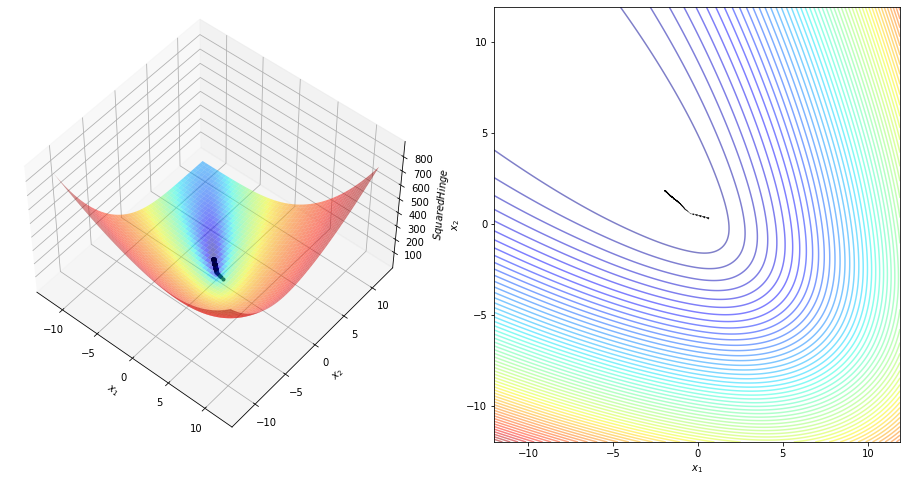

In [94]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)

grid = GridSearchCV(PrimalSVR(loss=squared_epsilon_insensitive, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.1),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt best r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-20, x_max=80, y_min=-40, y_max=60)
plt.savefig('./tex/img/svr_squared_eps_loss.png')

In [95]:
custom_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svr_squared_eps_cv_results.insert(0, 'optimizer', 'custom')
custom_primal_svr_squared_eps_cv_results.style.hide_index()

C,optimizer,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
1,custom,0.914336,0.977500,0.980024,12,6
10,custom,0.887345,0.982512,0.980024,7,4
100,custom,0.719462,0.967512,0.970074,4,3


In [96]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)

grid = GridSearchCV(SkLinearSVR(loss='squared_epsilon_insensitive'),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt best r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [97]:
sklearn_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
sklearn_primal_svr_squared_eps_cv_results.insert(0, 'optimizer', 'liblinear')
sklearn_primal_svr_squared_eps_cv_results.style.hide_index()

C,optimizer,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
1,liblinear,0.001110,0.977500,0.965023,18,9
10,liblinear,0.001477,0.977500,0.964948,12,7
100,liblinear,0.001678,0.980006,0.964948,13,7
